In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian, generate_total_hamiltonian, \
                                            generate_reduced_X_hamiltonian, generate_reduced_B_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator, \
                            check_approx_state_exact_state
from couplings.generate_coupling import optical_coupling_matrix, microwave_coupling_matrix, \
                                        generate_laser_D, generate_microwave_D,\
                                        generate_coupling_field

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

from hamiltonian.generate_states import generate_ground_states_approx, generate_excited_states_approx

In [2]:
script_dir = Path().parent.absolute().parent
script_dir

WindowsPath('C:/Users/Olivier/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Jg = [0,1]
#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = generate_ground_states_approx(Jg)

ground_states, H_X_red = generate_reduced_X_hamiltonian(ground_states_approx)

In [4]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [5]:
# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [1/2]
F_excited = [0]

excited_states_approx = generate_excited_states_approx(J_excited, F_excited, F1_excited, P=1)

excited_states, H_B_red = generate_reduced_B_hamiltonian(excited_states_approx)

In [6]:
for s in excited_states_approx:
    s.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

## Total Internal Hamiltonian

In [7]:
H_int, V_ref_int = generate_total_hamiltonian(H_X_red, H_B_red)
#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [8]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  generate_ground_states_approx(Js)

#Define excited states for laser
excited_states_laser_approx = excited_states_approx

#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = +1, Omega = 1)

In [9]:
laser_couplings = generate_coupling_field(ground_main_approx, excited_main_approx, 
                                        ground_states_laser_approx, excited_states_laser_approx,
                                        H_rot, QN, V_ref_int, pol_main = np.array([1,0,0]),
                                        pol_vec = [np.array([0,0,1]), np.array([1,0,0])])

In [10]:
D1 = generate_laser_D(H_rot, QN, 
                      laser_couplings[0]['ground_main'], laser_couplings[0]['excited_main'], 
                      laser_couplings[0]['excited_states'], Δ = 0)

## Microwave coupling

In [11]:
# Define ground states for microwaves
Js = [1]
ground_states_microwave1_approx =  generate_ground_states_approx(Js)

# Define excited states for microwaves
Je = [0]
excited_states_microwave1_approx =  generate_ground_states_approx(Je)

#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_μ1_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0)
excited_μ1_main_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**0, Omega = 0)

In [12]:
microwave_couplings = generate_coupling_field(ground_μ1_main_approx, excited_μ1_main_approx, 
                                            ground_states_microwave1_approx, excited_states_microwave1_approx,
                                            H_rot, QN, V_ref_int, pol_main = np.array([0,0,1]),
                                            pol_vec = [np.array([0,0,1]), np.array([0,1,0])])

In [13]:
D_μ1 = generate_laser_D(H_rot, QN, 
                      microwave_couplings[0]['ground_main'], microwave_couplings[0]['excited_main'], 
                      microwave_couplings[0]['excited_states'], Δ = 0)

## Total Hamiltonian

[ 8.35867483e+04  4.07669373e+01  2.03831940e+01  0.00000000e+00
 -1.39719693e+05  2.14009705e+01  1.07021484e+01  0.00000000e+00
  1.10555227e+06  1.10555245e+06  1.10555263e+06  1.19692292e+06
  1.19691262e+06  1.19690232e+06  1.19689202e+06  1.19688172e+06
  0.00000000e+00]


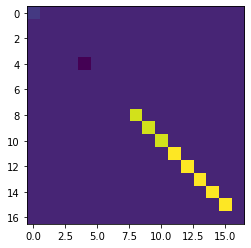

In [14]:
gnd_idx = QN.index(laser_couplings[0]['ground_main'])
H_rot = H_int.copy()
H_rot = H_rot - np.eye(H_rot.shape[0])*H_rot[gnd_idx,gnd_idx]
H_rot = H_rot + D1 + D_μ1
plt.imshow(H_rot.real)
print(np.diag(H_rot.real))

In [15]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87it/s]


In [16]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z
Pμy1 = Function("Pμy1")(t) # Polarization switching function for y
Pμz1 = Function("Pμz1")(t) # Polarization switching function for z

laser_fields = [(laser_couplings[0]['field']*Pz1, laser_couplings[0]['main_coupling']), 
                (laser_couplings[1]['field']*Px1, laser_couplings[1]['main_coupling'])]
microwave_fields = [(microwave_couplings[0]['field']*Pμy1, microwave_couplings[0]['main_coupling']), 
                    (microwave_couplings[1]['field']*Pμz1, microwave_couplings[1]['main_coupling'])]
detunings = [[QN.index(exc) for exc in laser_couplings[0]['excited_states']]]
detunings += [[QN.index(exc) for exc in microwave_couplings[0]['excited_states']]]

In [17]:
n_states = H_rot.shape[0]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields+microwave_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [18]:
Ωl = Symbol('Ωl', real = True)
Ωlc = Symbol('Ωlᶜ', real = True)
Ωμ = Symbol('Ωμ', real = True)
Ωμc = Symbol('Ωμᶜ', real = True)
H_symbolic = H_symbolic.subs(Ωs[0][0],Ωl).subs(Ωs[0][1],Ωlc)
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωl).subs(Ωs[1][1],Ωlc)
H_symbolic = H_symbolic.subs(Ωs[2][0],Ωμ).subs(Ωs[2][1],Ωμc)
H_symbolic = H_symbolic.subs(Ωs[3][0],Ωμ).subs(Ωs[3][1],Ωμc)

H_symbolic

Matrix([
[           Δ2 + 83586.7483215332,                               0,                                0,                                0,                               0, 0.290807911472161*I*Ωμ*Pμz1(t),    0.411234074581972*Ωμ*Pμy1(t),  0.290764892751861*I*Ωμ*Pμz1(t), -0.499983382824011*I*Ωμ*Pμz1(t),   -0.707100975358803*Ωμ*Pμy1(t), -0.500008409156251*I*Ωμ*Pμz1(t),                               0,                               0,                               0,                               0,                               0,                            0],
[                               0,           Δ2 + 40.7669372558594,                                0,                                0, -0.333901922157883*I*Ωμ*Pμz1(t),   -0.49999180136918*Ωμ*Pμy1(t), -0.353586231008722*I*Ωμ*Pμz1(t),                               0,   -0.290736980011639*Ωμ*Pμy1(t), -0.205594736946309*I*Ωμ*Pμz1(t),                               0, -0.578405249432978*I*Ωμ*Pμz1(t),   -0.578433636785611*Ωμ*Pμy1(t

In [19]:
# ρ = generate_density_matrix_symbolic(n_states)
# matrix_mult_sum = zeros(n_states, n_states)
# for C,Cᶜ in tqdm(zip(C_array, C_conj_array), disable = False):
#     idC = np.nonzero(C)
#     idCᶜ = np.nonzero(Cᶜ)
#     val = C[idC][0]*Cᶜ[idCᶜ][0]*ρ[idC[-1],idCᶜ[0]][0]
#     matrix_mult_sum[idC[0][0],idCᶜ[-1][0]] += val   

# Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)
# a = -0.5 * (Cprecalc@ρ + ρ@Cprecalc)

# system = zeros(n_states, n_states)
# system += matrix_mult_sum
# system += a

In [20]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


In [21]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

In [22]:
system[0]

-1.0*I*(-0.500008409156251*I*Ωμ*ρ₁₀,₀*Pμz1(t) + 0.290807911472161*I*Ωμ*ρ₅,₀*Pμz1(t) + 0.411234074581972*Ωμ*ρ₆,₀*Pμy1(t) + 0.290764892751861*I*Ωμ*ρ₇,₀*Pμz1(t) - 0.499983382824011*I*Ωμ*ρ₈,₀*Pμz1(t) - 0.707100975358803*Ωμ*ρ₉,₀*Pμy1(t) - 0.500008409156251*I*Ωμᶜ*ρ₀,₁₀*Pμz1(t) + 0.290807911472161*I*Ωμᶜ*ρ₀,₅*Pμz1(t) - 0.411234074581972*Ωμᶜ*ρ₀,₆*Pμy1(t) + 0.290764892751861*I*Ωμᶜ*ρ₀,₇*Pμz1(t) - 0.499983382824011*I*Ωμᶜ*ρ₀,₈*Pμz1(t) + 0.707100975358803*Ωμᶜ*ρ₀,₉*Pμy1(t))

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [23]:
# import julia
# julia.install()

In [24]:
from julia import Main

In [25]:
nprocs = 6

Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("../utils/general_ode_functions.jl")
end
""")

print(Main.eval("procs()"))

[1 2 3 4 5 6]


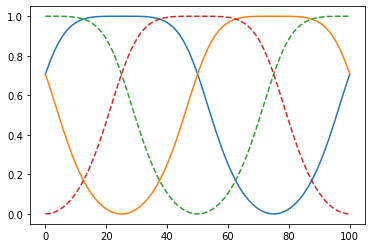

In [26]:
Px = Main.eval("[sine_wave(ti, 1e6, 0) for ti = range(0,1/1e6,length=101)]")
Pz = Main.eval("[sine_wave(ti, 1e6, π) for ti = range(0,1/1e6,length=101)]")
Pμy = Main.eval("[sine_wave(ti, 1e6, 0+π/2) for ti = range(0,1/1e6,length=101)]")
Pμz = Main.eval("[sine_wave(ti, 1e6, π+π/2) for ti = range(0,1/1e6,length=101)]")
normalization = np.sqrt(Px**2+Pz**2)
normalizationμ = np.sqrt(Pμy**2 + Pμz**2)
plt.plot(np.array([Px,Pz]).T/normalization[:,np.newaxis])
plt.plot(np.array([Pμy,Pμz]).T/normalizationμ[:,np.newaxis], ls = '--')

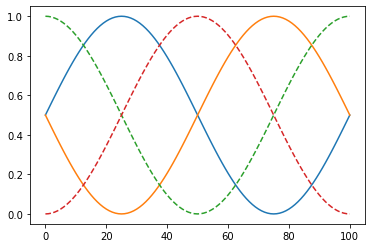

In [27]:
Px = Main.eval("[sine_wave(ti, 1e6, 0) for ti = range(0,1/1e6,length=101)]")
Pz = Main.eval("[sine_wave(ti, 1e6, π) for ti = range(0,1/1e6,length=101)]")
Pμy = Main.eval("[sine_wave(ti, 1e6, 0+π/2) for ti = range(0,1/1e6,length=101)]")
Pμz = Main.eval("[sine_wave(ti, 1e6, π+π/2) for ti = range(0,1/1e6,length=101)]")
normalization = np.sqrt(Px**2+Pz**2)
normalizationμ = np.sqrt(Pμy**2 + Pμz**2)
plt.plot(np.array([Px,Pz]).T)
plt.plot(np.array([Pμy,Pμz]).T, ls = '--')

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [28]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tνp1 = p[2]
\t\tΔ1 = p[3]
\t\tΩlᶜ = conj(Ωl)

\t\tΩμ = p[4]
\t\tνp2 = p[5]
\t\tΔ2 = p[6]
\t\tΩμᶜ = conj(Ωμ)

\t\tPx1 = sine_wave(t, νp1, π/2 + π)
\t\tPz1 = sine_wave(t, νp1, π/2)

\t\tPμy1 = sine_wave(t, νp2, π/2 + π + π/2)
\t\tPμz1 = sine_wave(t, νp2, π/2 + π/2)
"""

In [29]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ωl = p[1]
		νp1 = p[2]
		Δ1 = p[3]
		Ωlᶜ = conj(Ωl)

		Ωμ = p[4]
		νp2 = p[5]
		Δ2 = p[6]
		Ωμᶜ = conj(Ωμ)

		Px1 = sine_wave(t, νp1, π/2 + π)
		Pz1 = sine_wave(t, νp1, π/2)

		Pμy1 = sine_wave(t, νp2, π/2 + π + π/2)
		Pμz1 = sine_wave(t, νp2, π/2 + π/2)



In [30]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [31]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

In [45]:
for line in ode_fun.split('\n')[15:30]:
    print(line)

		Pμy1 = sine_wave(t, νp2, π/2 + π + π/2)
		Pμz1 = sine_wave(t, νp2, π/2 + π/2)
		du[1,1] = -1.0*1im*(-0.500008409156251*1im*Ωμ*ρ[11,1]*Pμz1 + 0.290807911472161*1im*Ωμ*ρ[6,1]*Pμz1 + 0.411234074581972*Ωμ*ρ[7,1]*Pμy1 + 0.290764892751861*1im*Ωμ*ρ[8,1]*Pμz1 - 0.499983382824011*1im*Ωμ*ρ[9,1]*Pμz1 - 0.707100975358803*Ωμ*ρ[10,1]*Pμy1 - 0.500008409156251*1im*Ωμᶜ*ρ[1,11]*Pμz1 + 0.290807911472161*1im*Ωμᶜ*ρ[1,6]*Pμz1 - 0.411234074581972*Ωμᶜ*ρ[1,7]*Pμy1 + 0.290764892751861*1im*Ωμᶜ*ρ[1,8]*Pμz1 - 0.499983382824011*1im*Ωμᶜ*ρ[1,9]*Pμz1 + 0.707100975358803*Ωμᶜ*ρ[1,10]*Pμy1)
		du[1,2] = -1.0*1im*(-0.500008409156251*1im*Ωμ*ρ[11,2]*Pμz1 + 0.290807911472161*1im*Ωμ*ρ[6,2]*Pμz1 + 0.411234074581972*Ωμ*ρ[7,2]*Pμy1 + 0.290764892751861*1im*Ωμ*ρ[8,2]*Pμz1 - 0.499983382824011*1im*Ωμ*ρ[9,2]*Pμz1 - 0.707100975358803*Ωμ*ρ[10,2]*Pμy1 - 0.578405249432978*1im*Ωμᶜ*ρ[1,12]*Pμz1 + 0.578433636785611*Ωμᶜ*ρ[1,13]*Pμy1 - 0.236156135505686*1im*Ωμᶜ*ρ[1,14]*Pμz1 - 0.333901922157883*1im*Ωμᶜ*ρ[1,5]*Pμz1 + 0.49999180136918*Ωμᶜ*ρ[1,6

### Generate density matrix

In [32]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [33]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [34]:
T = 6.3
ρ_ini = np.zeros(H_rot.shape, dtype = 'complex')

for J in range(0,2):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()

In [35]:
Γ = 2*np.pi * 1.56e6


Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ωl = Γ
    Δ1 = 0
    νp1 = 1e6
    Ωμ = Γ
    Δ2 = 0
    νp2 = 1e6
    p = [Ωl, νp1, Δ1, Ωμ, νp2, Δ2]
end
""")

In [44]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 5.17 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [37]:
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [40]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false);
tmp = 0
""");

Wall time: 1.04 s


0

In [41]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

2.9083348797340483

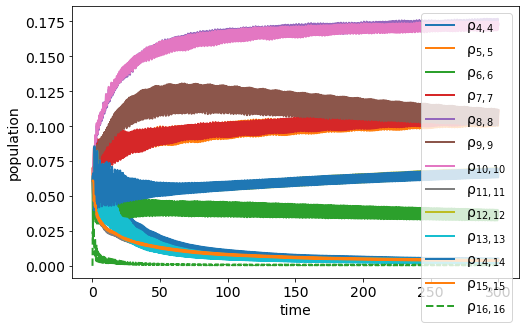

In [42]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '--' if idx in [16] else '-'
    if idx not in [0,1,2,3]:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
#         ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
        ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1]].real/1e6, axis = 0), t_array)*Main.Γ

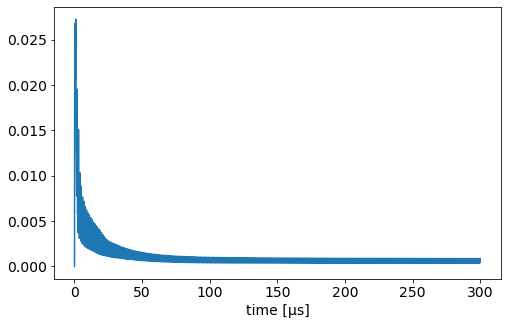

In [43]:
exc_F0 = pop_results[-1,:]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, exc_F0)

ax.set_xlabel('time [μs]')

set_fontsize(ax, 14)

In [ ]:
fig, axes = plt.subplots(figsize = (8,10), nrows = len(pop_results)-1, sharex = True)
for idx, pop in enumerate(pop_results[:-1]):
    axes[idx].plot(t_array, pop)

axes[idx].set_xlabel('time [μs]')
for ax in axes:
    set_fontsize(ax, 14)

### Parameter scan for polarization switching frequency

In [42]:
Main.eval("""
@everywhere params = [val*Γ/(2pi) for val in 0:5/401:5]""")

In [43]:
# defining a progress bar to keep track of the ODE ensemble solver progress
# Main.eval("using ProgressMeter")
# Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

In [44]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[{n_states}])) for j in 1:size(sol.u)[1]]), false
end""")

In [45]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p);
""");

In [46]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [Ωl, params[i], Δ1, Ωμ, params[i], Δ2])
end
""")

In [47]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [48]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

63.9462077

In [49]:
results_νs = Main.eval("sim.u")

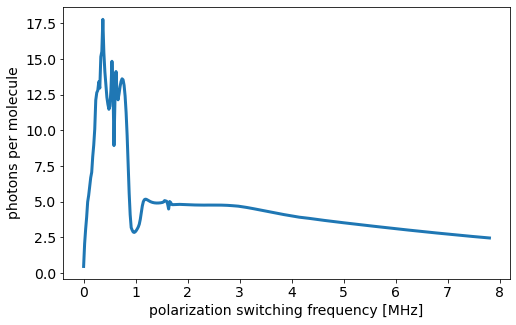

In [50]:
νs = Main.params
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(νs/1e6, results_νs*Γ, lw = 3)
ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

In [51]:
νs[np.argmax(results_νs)]

369576.05985037406

### Parameter scan for Ωl and Ωμ

In [52]:
Ωls = np.linspace(0,3,31)*Γ
Ωμs = np.linspace(0,3,31)*Γ
params = np.array(np.meshgrid(Ωls, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [53]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [params[i,1], 0.37e6, Δ1, params[i,2], 0.37e6, Δ2])
end
""")

In [54]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [55]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

74.3193126

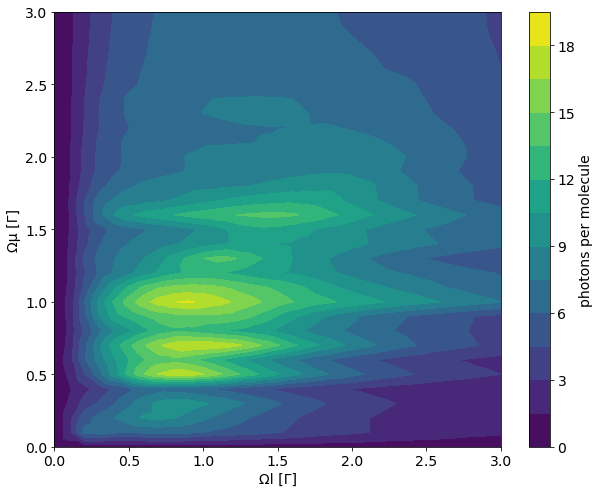

In [56]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]/Γ, params[:,1]/Γ, np.array(Main.eval("sim.u"))*Γ, levels = 15)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)